In [1]:
%load_ext tikzmagic
%matplotlib inline

# 레버리지와 아웃라이어

지금까지는 회귀분석의 성능을 향상시키기 위해 독립변수를 선택하는 방법을 공부했다. 이 절에서는 개별적인 데이터 레코드를 분석하는 방법을 학습힌다. 즉 지금까지 독립변수행렬 $X$의 열을 선택하거나 제거하는 방법을 공부했다면 이제는 독립변수행렬 $X$의 행을 조사하고 선택하는 방법을 알아본다. 

예제로는 보스턴 집값을 lstat 독립변수를 사용하여 선형회귀분석한 결과를 사용한다. 다만 여기에서는 전체 데이터를 다 사용하는 것이 아니라 앞부분의 10개 데이터 레코드만을 사용하여 회귀분석을 한다.

In [2]:
import statsmodels.api as sm

boston = sm.datasets.get_rdataset("Boston", "MASS").data
boston10 = boston.iloc[:10]  # 앞 부분 10개의 데이터만 사용

model10 = sm.OLS.from_formula("medv ~ scale(lstat)", boston10)
result10 = model10.fit()

seaborn 패키지의 `regplot` 함수로 선형회귀분석 결과를 그림으로 그리면 다음 그림과 같다. 이 그림에서는 0번 데이터 레코드부터 9번 데이터 레코드까지 10개의 데이터 레코드 각각에 대해 인덱스 번호를 붙어서 표시하였다.

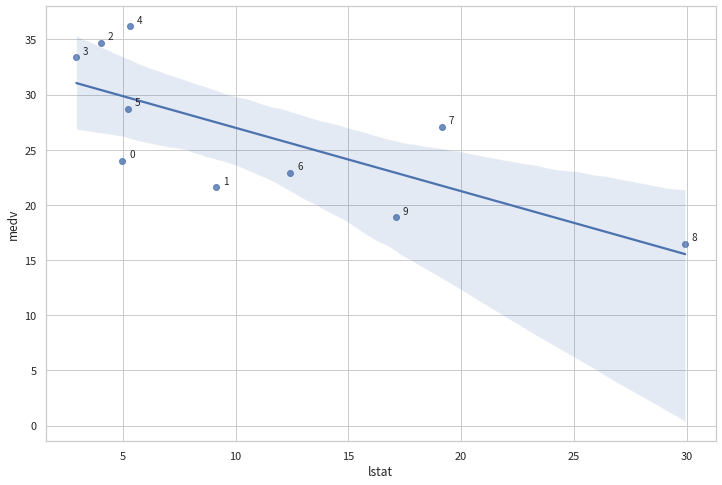

In [3]:
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.regplot(x="lstat", y="medv", data=boston10)
for i, r in boston10.iterrows():
    plt.annotate(i, (r.lstat + 0.3, r.medv + 0.3))
plt.show()

## 레버리지

선형회귀분석을 실시하고 나면 찾아낸 가중치에 따른 예측값 $\hat{y}$을 다음 공식으로 계산할 수 있다. 

$$
\hat{y} = X \hat{w} = X(X^TX)^{-1}X^T y
$$

위 식에서 $y$ 앞에 있는 $X(X^TX)^{-1}X^T$ 행렬을 <b>영향도행렬(influence matrix)</b> 혹은 <b>hat행렬(hat-matrix)</b>이라고 부르고 기호로 $H$라고 쓴다.

$$
H = X(X^TX)^{-1}X^T
$$

데이터의 개수가 $N$개일 때 영향도행렬은 $N\times N$ 크기의 행렬이 된다.

영향도행렬에서 가장 중요한 부분은 대각성분이다. 영향도행렬 $H$의 $i$번째 대각성분 $H_{ii}$을 <b>레버리지(leverage)</b> $h_i$라고 부른다.

$$
h_i = H_{ii}
$$

영향도행렬의 크기가 $N\times N$이므로 레버리지의 개수는 데이터 개수와 같다. 즉, $i$번째 데이터에 대해 $i$번째 레버리지가 대응되는 구조로 각각의 데이터는 하나의 레버리지 값을 가진다. 

$$
(x_i, y_i) \;\; \leftrightarrow \;\; h_i
$$

statsmodels 패키지의 선형회귀분석 결과 객체는 레버리지를 포함한 영향도 객체라는 객체를 출력하는 `get_influence` 메서드를 제공한다. 

In [4]:
influence10 = result10.get_influence()
influence10

영향도 객체는 `OLSInfluence` 클래스 객체로 `hat_matrix_diag` 속성에 레버리지 값을 저장하고 있다.

In [5]:
influence10.hat_matrix_diag

array([0.1534897 , 0.10519736, 0.1716263 , 0.19569161, 0.14747404,
       0.14949614, 0.10289462, 0.19668851, 0.62338413, 0.1540576 ])

## 잔차

앞에서 가중치 검정을 공부할 때 다음과 확률론적 가정을 사용하였다. ({ref}`subsection:linear-regression-probabilistic-assumptions` 참조)

    
> 교란항 $\varepsilon$은 기댓값이 0이고 분산이 $\sigma^2$인 정규분포를 따른다. 이 때 교란항의 분산 $\sigma^2$은 어떤 경우에도 변하지 않는다.  
>
> $$ \varepsilon \sim \mathcal{N}(0, \sigma^2) $$
    
이 가정을 사용하면 선형회귀분석으로 나온 잔차 $e$도 기댓값이 0인 정규분포를 따른다는 것을 증명할 수 있다. 

$$
e \sim \mathcal{N}\left(0, \sigma_e^2 \right)
$$
    
이 때 잔차 $e$의 분산 $\sigma_e^2$과 교란항의 분산 $\sigma^2$는 다음과 같은 관계를 가진다.
$$
\sigma_e^2 = \dfrac{N}{N-K-1} \sigma^2
$$

이 관계를 이용하여 교란항의 분산 $\sigma^2$을 추정할 수 있다.

$$
\hat{\sigma}^2 = \dfrac{e^Te}{N-K-1} = \dfrac{RSS}{N-K-1}
$$
    